### Introduction and Motivation

Machine learning courses often fixate on discriminative models (such as decision trees and linear models) to the point where many machine learning engineers ignore generative models (such as Gaussian mixture models and generative adversarial networks) altogether. In my experience, I think the same is often done for time series modeling and anomaly detection. It is my goal to introduce my readers to the world of simple generative models. As an example, I'll be discussing DGAs (we'll talk about DGAs in a bit).

It is my goal in this post to give my readers a taste of what generative models can do and why they are important tools in any data scientist's toolkit. 

I'll start with a motivating example in cyber security: detecting DGAs. I'll explain what DGAs are, why we care about them, and why discriminative models can sometimes fail miserably in finding them. I'll then discuss a simple generative model (the markov chain) and then finish with a few parting words on how to learn more. 

Many readers might (and probably will) ask why I am writing a post about domain generating algorithms (DGAs). DGAs have been done to death in the cyber security space! That is mostly true. There has been a lot of attention on DGAs and they have been covered quite thoroughly from a variety of different angles. However, data on DGAs is very convenient to find and easy to work with, so they present a nice data set to work on.

A big thanks to my friend Kate Highnam who introduced me to the world of DGAs and often patiently listens to my rants on statistics.

### What is a domain?

Before we define a domain generating algorithm, we first need to define a domain! Domains (or domain names) are single character strings that we use to communicate with a DNS server to tell the server what website we want to go to. The DNS server takes this string and connects us to the IP address or addresses of the servers that the domain belongs to.

For example: I might want to go to the domain "google.com". I would put Google into my search engine that would look up the servers Google runs to process requests for google.com and then return whatever those servers want to send back to me. 

Why do we like this? There are actually a ton of reasons that I won't get into, but the simplest reason is that it's hard to remember an IP address like 151.101.129.121 but easy to remember a domain name like lifewire.com.

Often in cyber security you will see domains printed as such: malware[.]com. The reason for this is that the domain may link to actual malware and inserting brackets avoids accident hyper link clicking.

### What is a domain generating algorithm?

DGAs are just pieces of code that produce domain names. They often have some set of rules such that the domains they generate look random but follow some set pattern. There are many uses for DGAs. Content distribution networks (CDN) and ad networks use DGAs to quickly create domains for transient content and to get around ad blocker tools. Bad actors (hackers and other miscreants) uses DGAs to disguise communications between a command and control server (C&C) and malware installed on a target computer.

We want to detect DGAs so that we can find instances where malware is communicating with its C&C, which acts like a sort of mother ship, and silence those communications. There is a lot more than can be said on this topic on the cyber security front, but I'm easily distracted and I want to at least try to stay on point. 

The basic procedure of using a DGA is to have your malware generate many (often hundreds r thousands) of domain names a day (cadence can vary depending on beaconing behavior). The bad actor will know what domains will be generated on that day because he created the DGA and so he can buy a few of those domains in advance and point them to his C&C server. Rinse and repeat to ensure that cyber security analysts never catch on to where your C&C.

What is hard about detecting malware DGAs is that they are intentionally trying NOT to be found! Hackers are always coming up with new DGAs to fool our DGA detection models. 

Below is a super simple example of a DGA from: https://en.wikipedia.org/wiki/Domain_generation_algorithm

You can also look at these resources to see actual DGAs that ahve been reverse engineered from malware: [Endgame Github](https://github.com/endgameinc/dga_predict/tree/master/dga_classifier/dga_generators), [Paul Chaignon Repo](https://github.com/pchaigno/dga-collection)

In [1]:
def generate_domain(year, month, day):
    """Generates a domain name for the given date."""
    domain = ""

    for i in range(16):
        year = ((year ^ 8 * year) >> 11) ^ ((year & 0xFFFFFFF0) << 17)
        month = ((month ^ 4 * month) >> 25) ^ 16 * (month & 0xFFFFFFF8)
        day = ((day ^ (day << 13)) >> 19) ^ ((day & 0xFFFFFFFE) << 12)
        domain += chr(((year ^ month ^ day) % 25) + 97)

    return domain

print "Sample Domain from DGA:", generate_domain(2018,5,1) + '.com'

Sample Domain from DGA: jjuyvunkbqidxxcl.com


### Discriminators vs Generators?

Let's discuss many of the more popular ways of identifying DGAs. First we can simply look up if someone else has identified a domain as a DGA using services like [virus total](https://www.virustotal.com/), [whois](https://www.whois.net/), or [DGArchive](https://dgarchive.caad.fkie.fraunhofer.de/).

A very popular next step is to train a discriminator to identify dgas from non-dgas. A discriminator is simply a model that 'learns' a hard or soft boundary between classes. There are numerous papers on how to use GBM, neural nets, and a host of other model types to detect DGAs. The work is quite interesting, but it is hard to produce novel research is such a saturated space. If you want to play around in this space, I recommend this fun [github project](https://github.com/andrewaeva/DGA).

The problem with discriminators is that they establish their class boundaries based on what they've seen. For the benign case this is usually fine. The nature of benign domain names rarely changes that much. DGAs, however, can change a lot as bad actors try to get around our detection models. Therefore, the decision boundary that worked for our train data might not work for our test data a few months after we deploy it (or may not work as well).

We can try to combat this with [generative models](https://stats.stackexchange.com/questions/12421/generative-vs-discriminative). These models try to find the distribution over each individual class. Rather than asking the question "is this domain class A or B?", we ask "is this class A?". Now because we are trying to model an entire distribution instead of just finding a decision boundary, generative models can be much less accurate than discriminative models. This is why discriminative models are favored in cyber security. Cyber teams need to feed potential DGAs through human agents and so need to lower false positive rates to keep queue sizes reasonable for their agents. [Here](http://www.raid-symposium.org/raid99/PAPERS/Axelsson.pdf) is a good discussion of this topic.

However, running both a generative model and discriminative model might allow a small cyber security team to get the best of both worlds:
* accurate decision boundaries that produce low FP rates
* a detection system that isn't 'over fit' to the train classes

If you felt like this went over your head just wait, things will become clearer with the examples.

### What is a markov chain?

Ok, so let's get started. There are many kinds of generative models. I've built generators from neural nets (like GANs and Autoencoders), kernel density estimates over hand crafted feature spaces, Gaussian processes, etc. But these are hard models to build and can be very finicky. I often feel like I am practicing black magic when trying to tune a GAN model.

So we're starting small. Markov models are simple models to understand but are SUPER powerful. I always try to use markov models if I can because you can implement them easily, often get great results, and they are easily interpreted. 

Let me preface next part of this section with a couple important notes. Firstly, I will be covering Markov chains in more detail in a later blog post on Markov Decision Processes (MDP) in the context of reinforcement learning, so forgive me if I move quickly over them. Second, my code for building a markov chain will be very crude and inefficient. This is because I wrote the code to be easy to understand and straight forward. In the MDP I will use a much more efficient methodology. 

In the early 1900s Andrey Markov produced some interesting work concerning discrete processes he called 'chains'. These chains were a set of successive states and a process that describes the movement from one state to the next. Each move is a single step and is based on a transition model. A Markov chain is based on the Markov Property. The Markov property states that given the present, the future is conditionally independent of the past. That’s it, the state in which the process is now it is dependent only from the state it was at 
t-1.

If we can empirically arrive at the transition matrix that describes the probability of transitioning from one state to another, then we can know the probability that a certain sequence of states was observed (given the assumption that the process has markovian properties).

### Building our DGA generator

So how do we use the markov chain? Well, we can think of each character in a domain as a state. We can then determine the probability to seeing a certain character given the character before it. Now, any linguist worth their salt will tell you that language is more complex than this (especially English) and that words do not perfectly adhere to the markov property. Well, it's an approximation!

Let's put this into practice.

First, get the all_legit.txt and all_dga.txt files from this handy dandy source: https://github.com/andrewaeva/DGA

The all_legit.txt contains the alexa one million dataset of popular benign domains. The all_dga.txt contains actual examples of dgas from popular malware families.

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_alexa1m = pd.read_csv("all_legit.txt",header=None)
df_alexa1m.columns = ['domains']
df_alexa1m.domains = df_alexa1m.domains.apply( lambda x: x.split(".")[0] )
df_alexa1m.domains = df_alexa1m.domains.apply( lambda x: x.lower() )

We then encode each possible character in the domain as an index value and store those values in a dictionary (we also create a look up dictionary for convenience). This is a popular trick to transform strings into a vector format that a model can ingest. Here I do it because it makes my life easier filling in the transition matrix later on. I'm lazy.

We include '!' and '@' as start and stop characters to represent the probability of starting or ending with a certain character. This is important or our transition matrix won't take into account the probability of having a particular start or stop character!

In [4]:
character_dict = {}
i = 0
for domain in df_alexa1m.domains.values:
    for char in domain:
        if char not in character_dict.keys():
            character_dict[char] = i
            i += 1
        else:
            pass

# add padding chars
character_dict['!'] = i
i += 1
character_dict['@'] = i

character_lookup_dict = {v: k for k, v in character_dict.iteritems()} # python 2 version
#character_dict_lookup = {v: k for k, v in character_dict.items()} # python 3 version

We then initialize a matrix that is size nxn where n is the number of possible states (characters). The way we arrive at our transition probabilities is by counting the instances of those transitions in our alexa one million set. Since some transitions might not exist at all (our data might not be 100% representative of the true population) we initialize every transition count to 1 so that when we normalize the transition counts to get probability scores no probability will be exactly zero (just really really close). We are therefore making the assumption that no transition is exactly impossible, only possibly highly unlikely.

In [5]:
num_chars = np.max( character_dict.values() ) + 1
transition_matrix = np.ones((num_chars,num_chars))

Then we simply count the number fo transitions we see in our alexa one million domains!

In [6]:
for domain in df_alexa1m.domains.values:
    domain = '!' + domain + '@'
    domain = [ character_dict[x] for x in domain]
    for i, char in enumerate(domain):
        if i+1 <= len(domain)-1:
            char_1 = domain[i]
            char_2 = domain[i+1]
            transition_matrix[char_1][char_2] += 1

We normalize our counts to get probabilities.

In [7]:
row_sums = transition_matrix.sum(axis=1)
transition_matrix = transition_matrix / row_sums[:, np.newaxis]

So how do we interpret this transition matrix? Well, each value in the matrix represents the probability of transitioning from one state (character) to another. For instance, what is the probability of transitioning to 'a' given that we are in state 'b'?

In [8]:
char_a = character_dict['a']
char_b = character_dict['b']
print "Prob of going from b -> a: {}%".format( 100.00 * transition_matrix[char_b,char_a] )

Prob of going from b -> a: 15.7747477433%


Now we could try to find the probability of seeing a particular domain as the power series of the probability of each of it's character transitions...but we will often run into underflow issues (take a peak at the transition matrix to see why). Instead we will borrow from our handy stats textbooks and just take the summed log likelihoods.

In [9]:
log_liklihood_list = []
for domain in df_alexa1m.domains.values:
    domain = '!' + domain + '@'
    domain = [ character_dict[x] for x in domain]
    log_liklihood = 0
    for i, char in enumerate(domain):
        if i+1 <= len(domain)-1:
            char_1 = domain[i]
            char_2 = domain[i+1]
            transition_probability = transition_matrix[char_1,char_2]
            log_liklihood += np.log(transition_probability)
    # normalize by length
    log_liklihood = log_liklihood / len(domain)
    log_liklihood_list.append(log_liklihood) 
df_alexa1m['LL'] = log_liklihood_list

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

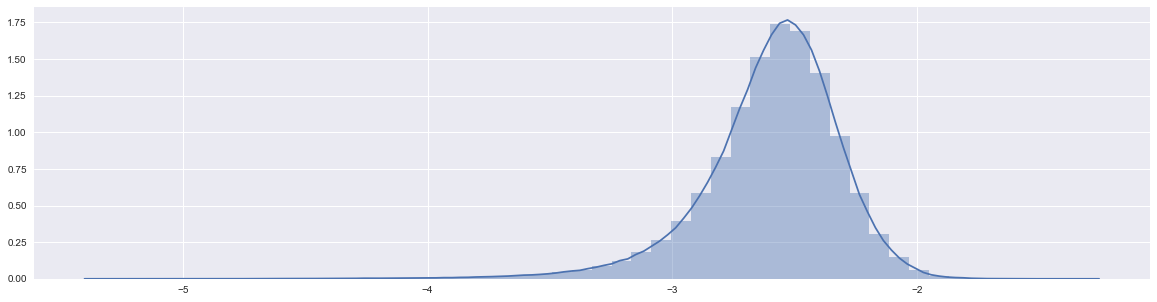

In [11]:
plt.figure(figsize=(20,5))
sns.distplot( df_alexa1m.LL.values )
plt.show()

Above we see the distribution of log likelihoods for the alexa one million domains given our markov chain model. This is cool to look at, but tells us very little. Let's compare this to the distribution over the zeus dga domains (zeus is a famous family of malware which sometimes makes use of particular domain generators).

In [12]:
df_dgas = pd.read_csv("all_dga.txt",header=None)
df_dgas.columns = ['domains']
df_dgas['dga_family'] = df_dgas.domains.apply(lambda x: x[-1])
df_dgas.domains = df_dgas.domains.apply( lambda x: x.split(".")[0] )
df_dgas.domains = df_dgas.domains.apply( lambda x: x.lower() )

def dga_family(x):
    if x == '0':
        return "legit"
    elif x == '1':
        return "cryptolocker"
    elif x == '2':
        return "zeus"
    elif x == '3':
        return "pushdo"
    elif x == '4':
        return "rovnix"
    elif x == '5':
        return "tinba"
    elif x == '6':
        return "conflicker"
    elif x == '7':
        return "matsnu"
    elif x == '8':
        return "rambo"
    else:
        return None
    
df_dgas.dga_family = df_dgas.dga_family.apply(lambda x: dga_family(x))

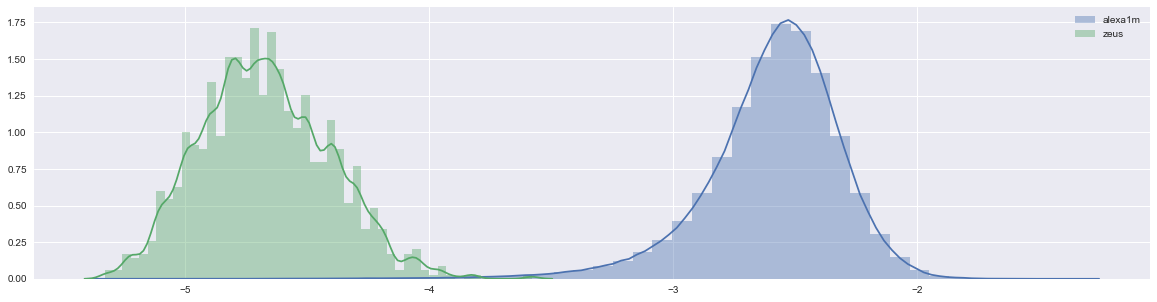

In [13]:
log_liklihood_list = []
for domain in df_dgas.domains.values:
    domain = '!' + domain + '@'
    domain = [ character_dict[x] for x in domain]
    log_liklihood = 0
    for i, char in enumerate(domain):
        if i+1 <= len(domain)-1:
            char_1 = domain[i]
            char_2 = domain[i+1]
            transition_probability = transition_matrix[char_1,char_2]
            log_liklihood += np.log(transition_probability)
    # normalize by length
    log_liklihood = log_liklihood / len(domain)
    log_liklihood_list.append(log_liklihood) 
df_dgas['LL'] = log_liklihood_list

plt.figure(figsize=(20,5))
sns.distplot( df_alexa1m.LL.values ,label = 'alexa1m')
sns.distplot( df_dgas[df_dgas.dga_family == 'zeus'].LL.values ,label='zeus')
plt.legend()
plt.show()

As we can see, the zeus domains all have MUCH lower log likelihoods than the alexa one million domains. What does this mean? It means that given the transition probabilities in the alexa one million set, the zeus set is very unlikely to have been generated using the same process.

Ok...so what? Well, we just built a model that can tell that the zeus domains are not benign WITHOUT training on a single zeus domain. We didn't need any samples of the zeus dgas. Theoretically, we could detect DGAs we've never seen before and never trained on. Now there are a variety of nuances, practical considerations, and qualifications to that statement...but I think this is pretty neato.

Now some of you out there are thinking...this is super cool, look how easy it would be to draw a line between those humps to separate zeus domains from alexa domains. With generators we look at the probability or likelihood that a data point came from the process our generator describes. We're typically not in the business of drawing lines (although we might for practical purposes). Let's look at why drawing lines can be bad.

Below I'm going to plot the alexa domains and zeus domains against each other with domain length on the y axis and log likelihood (from our markov model) on the x axis. These distributions look pretty different right? We could easily draw a line between then to define the zeus and alexa classes!

In [14]:
df_alexa1m['length'] = df_alexa1m.domains.apply(lambda x: len(x))
df_dgas['length'] = df_dgas.domains.apply(lambda x: len(x))

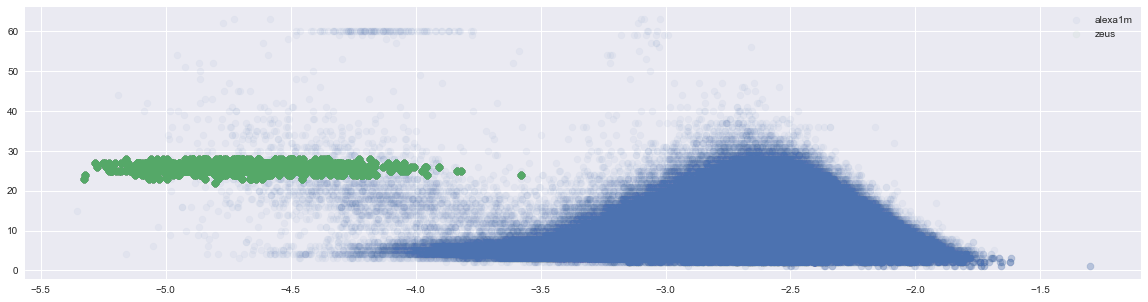

In [15]:
plt.figure(figsize=(20,5))
plt.scatter(df_alexa1m.LL.values,df_alexa1m.length.values,alpha=.05,label='alexa1m')
plt.scatter(df_dgas[df_dgas.dga_family == 'zeus'].LL.values,df_dgas[df_dgas.dga_family == 'zeus'].length.values,alpha=.05,label='zeus')
plt.legend()
plt.show()

Below I've drawn our line. Everything looks fine, right? This is a model that we can be proud of and deploy into production!

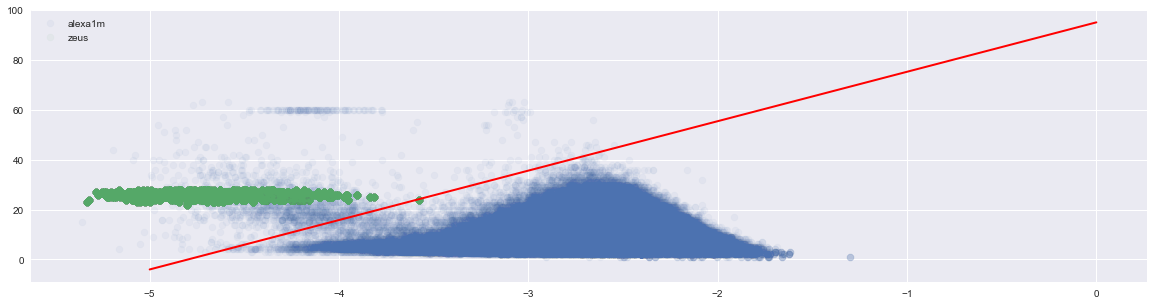

In [16]:
plt.figure(figsize=(20,5))
plt.scatter(df_alexa1m.LL.values,df_alexa1m.length.values,alpha=.05,label='alexa1m')
plt.scatter(df_dgas[df_dgas.dga_family == 'zeus'].LL.values,df_dgas[df_dgas.dga_family == 'zeus'].length.values,alpha=.05,label='zeus')
plt.legend()
plt.plot([0, -5.0], [95, -4.0], 'r-', lw=2)
plt.show()

But what if hackers figure out (or outright guess) that domain length is a feature in our model? It’s pretty plausible that a hacker might do this and I may address that in a future blog post. Let's see what happens when the "hacker" shortens the length of the zeus domains to match the alexa domains more closely.

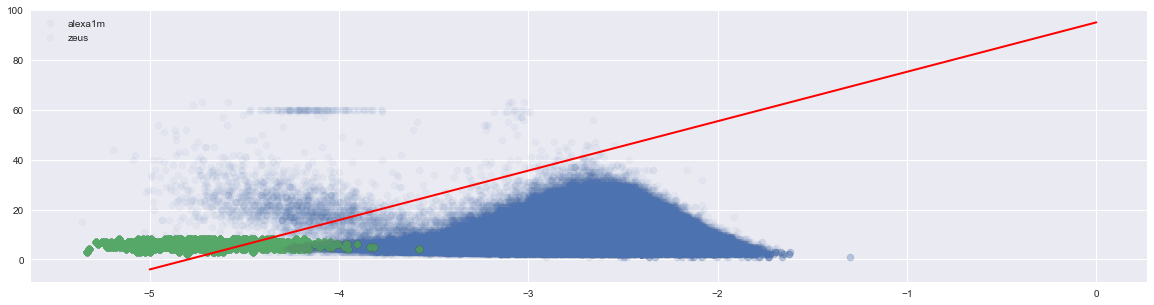

In [17]:
plt.figure(figsize=(20,5))
plt.scatter(df_alexa1m.LL.values,df_alexa1m.length.values,alpha=.05,label='alexa1m')
plt.scatter(df_dgas[df_dgas.dga_family == 'zeus'].LL.values,df_dgas[df_dgas.dga_family == 'zeus'].length.values - 20.0,alpha=.05,label='zeus')
plt.legend()
plt.plot([0, -5.0], [95, -4.0], 'r-', lw=2)
plt.show()

Suddenly our line doesn't seem like such a great decision boundary! However, you'll notice that the zeus domains are still at the very tail end of our generative model (If this isn't clear, try graphing each axis separately as a histogram. Scatter plots can make interpreting densities difficult). This is a toy example of how a generative model might tell us that something is wrong even if the discriminative model doesn't detect anything bad.

### Practical Tips for Using Your Model

Before I turn you loose on the world with your new found knowledge, I wanted to go through a few practical concerns. This isn't a thorough treatment of how to use generative models, so please don't take this code and try to productionize a model! 

So how do we sue our model? Well, the easiest way is to use our log likelihood scores as anomaly scores. The bigger the LL the less likely we are to have seen that data point given the train data. We could then send x% of the anomalies to our cyber security team for a thorough analysis. 

That's not an ideal solution for two reasons. Firstly, it assumes that lower likelihood scores are 'better'. However, we know that hackers try to make DGAs look like non-DGAs (One interesting example: [DeepDGA: Adversarially-Tuned Domain Generation and Detection](https://arxiv.org/abs/1610.01969)). What if a hacker uses adversarial training techniques to produce DGAs that perfectly fit our detection model? We might start to see unusually low log likelihoods (if the hacker is sloppy). More importantly, it's hard to tune log likelihood. We would ideally like to use the model in a way such that we can intelligently tune it's sensitivity.

To this end, we'll discuss (at a very high level) two methods: Kernel Density Estimation and Gaussian Mixture Models. I'm going to gloss over quite a bit of stats and assumptions. I don't feel too guilty given that this is just a fun blog post...if you are a statistical purist; please don't hate me too much!

First we'll cover a very simple trick: [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (kde). KDEs are a smoothing technique used to approximate a continuous probability density function from finite data. KDEs are useful for a lot of problems in signal processing and econometrics. Typically we sue caution when fitting KDEs given that our choice of kernel and kernel parameters can lead to over fitting...but our distributions here are simple and so we don't need to be too worried. 

Below I've fit a one dimensional kde to the histogram of our markov model likelihoods. Do you think the kde accurately represents the distribution of likelihoods?

In [18]:
from scipy.stats import gaussian_kde

class Kernel_Density_Estimate(object):
    """Kenerl Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance
    # of theinput data. To make the results comparable to the other methods,
    # we devide the bandwidth by the sample standard deviation here.
    
    def __init__(self,bandwidth=0.2):
        self.bandwidth = bandwidth
        self.kde = None
        
    def train(self, x, **kwargs):
        self.kde = gaussian_kde(x, bw_method = self.bandwidth / x.std(), **kwargs)
        
    def predict(self, x):
        return self.kde.evaluate(x)

In [19]:
kde = Kernel_Density_Estimate(bandwidth=.05)
kde.train( df_alexa1m.LL.values )
x = np.linspace(-6,0,1000)
pdf = kde.predict(x)

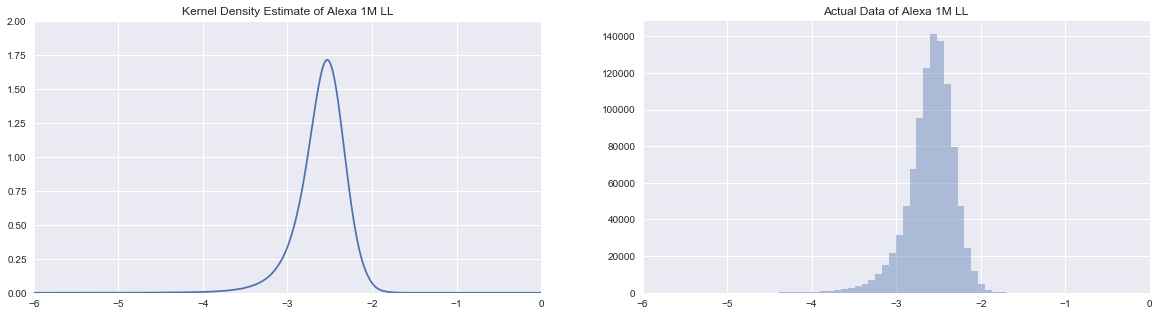

In [20]:
fig = plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(x,pdf)
plt.xlim(-6,0)
plt.ylim(0,2)
plt.title("Kernel Density Estimate of Alexa 1M LL")

plt.subplot(1, 2, 2)
sns.distplot(df_alexa1m.LL.values, kde=False)
plt.xlim(-6,0)
plt.title("Actual Data of Alexa 1M LL")
plt.show()

Now that we have an estimate of the probability density function (pdf) of our data given our markov model we can artificially discretize it and then approximate the cumulative density function (cdf) of our data. With the cdf we can find the 99% credibility interval (yes, I mean credibility and not confidence!) of the data. Assuming our alexa1m set is representative of our test data and our assumptions around our model and cdf approximation are correct, then we will identify 1% of our benign domains as DGAs. 

Below I print the % of DGAs caught, the % of alexa1m domains accidently caught, and the 99% credible interval. You'll notice that this is a two-tailed credible interval. Why do I consider anomalies with very low LLs? Well, a hacker might be producing domains using an Oracle he created based on the alexa1m data (that he knows is a popular set to build DGA detectors on). His DGAs might look TOO much like the alexa1m set and so be perfectly modeled by the markov chain. It turns out that this isn't the case here, but it's interesting to think about.

In [21]:
cdf = 100.00 * pdf / pdf.sum()
cdf = cdf.cumsum()

lower_bound = x[ cdf[cdf <= .5].shape[0] ].round(2)
upper_bound = x[ cdf[cdf <= 99.5].shape[0] ].round(2)
print "99% Credible Interval for LL: {} : {}".format(lower_bound, upper_bound)

DGA_Anomalies = 0
for LL in df_dgas[df_dgas.dga_family == 'zeus']['LL']:
    if LL < lower_bound or LL > upper_bound:
        DGA_Anomalies += 1
        
Alexa_Anomalies = 0
for LL in df_alexa1m.LL:
    if LL < lower_bound or LL > upper_bound:
        Alexa_Anomalies += 1
        
dgas_caught = np.round(100.0 * DGA_Anomalies / df_dgas[df_dgas.dga_family == 'zeus'].shape[0],1)
alexa1m_caught = np.round(100.0 * Alexa_Anomalies / df_alexa1m.shape[0],1)

print "Percent of Zeus Domains Caught: {}% \nPercent of Alexa 1M Domains Caught: {}%".format(dgas_caught,alexa1m_caught)

99% Credible Interval for LL: -3.72 : -1.99
Percent of Zeus Domains Caught: 99.9% 
Percent of Alexa 1M Domains Caught: 0.9%


Not bad! This is a pretty good catch rate! However, we need to take into account the base rate fallacy. If you are not familiar with the base rate fallacy, I **HIGHLY** recommend you read through this short paper: [The Base-Rate Fallacy and its Implications for the
Difficulty of Intrusion Detection](http://www.raid-symposium.org/raid99/PAPERS/Axelsson.pdf).

Basically, the number of benign domains we see in the real world is always FAR bigger than the number of DGAs. We can use this information to see how many benign domains we will flag for our human cyber security agents to detect vs the number of actual DGAs.

Let's say we see 10,000,000 unique domains a day and that .1% of these are actual DGAs. That means that 10,000 DGAs  and 9,990,000 benign domains exist in our proxy logs.

$.999 * 10,000 = 9,990$ <br>
$.001 * 10,000 = 10$ <br>

We catch 9,990 DGAs and miss 10 at the 99% credible interval.

$.009 * 9,990,000 = 89,910$ <br>
$.991 * 9,990,000 = 9,900,090$ <br>

Unfortunately we falsely identify almost 90,000 benign domains as DGAs! That means about 9 / 10 domains sent to our human agents will NOT be malicious (and this is often optimistic compared to reality). 

Just for fun, let's use look at the one tailed 99.5% credibility interval.

In [22]:
cdf = 100.00 * pdf / pdf.sum()
cdf = cdf.cumsum()

lower_bound = x[ cdf[cdf <= .5].shape[0] ].round(2)
print "99.5% Credible Interval for LL: <{}".format(lower_bound)

DGA_Anomalies = 0
for LL in df_dgas[df_dgas.dga_family == 'zeus']['LL']:
    if LL < lower_bound:
        DGA_Anomalies += 1
        
Alexa_Anomalies = 0
for LL in df_alexa1m.LL:
    if LL < lower_bound:
        Alexa_Anomalies += 1
        
dgas_caught = np.round(100.0 * DGA_Anomalies / df_dgas[df_dgas.dga_family == 'zeus'].shape[0],1)
alexa1m_caught = np.round(100.0 * Alexa_Anomalies / df_alexa1m.shape[0],1)

print "Percent of Zeus Domains Caught: {}% \nPercent of Alexa 1M Domains Caught: {}%".format(dgas_caught,alexa1m_caught)

99.5% Credible Interval for LL: <-3.72
Percent of Zeus Domains Caught: 99.9% 
Percent of Alexa 1M Domains Caught: 0.5%


We'll use the same assumptions as before, but with the one tailed 99.5% credibility interval. 

$.999 * 10,000 = 9,990$ <br>
$.001 * 10,000 = 10$ <br>

We catch 9,990 DGAs and miss 10 at the 99% credible interval.

$.005 * 9,990,000 = 49,950$ <br>
$.995 * 9,990,000 = 9,940,050$ <br>

Now only about 8 / 10 domains sent to our human agents will NOT be malicious. 

Perhaps we can do a little better than that! Rather than just considering the LL from our markov model, we'll also consider the length of the domain as a feature of interest. Now that we have two dimensions to consider, we could use a 2D kernel...but as the number of dimensions gets higher, that gets tricky. Instead, we'll use a mixture model to approximate the distribution of our data. A mixture model combines a set of simple distributions (like a normal/Gaussian, Poisson , or beta distribution) together to create something more complex (like the basis functions in Fourier transforms that I cover in my time series course). There are really complicated mixture models that we could sue, but we're going to make some naive assumptions. We'll assume that we can model our data as a combination of Gaussian distributions (we call this a gmm or [Gaussian mixture model](https://en.wikipedia.org/wiki/Mixture_model)).

I'll skip over the details of GMMs, but I highly encourage you to check them out since they are super cool and highly useful. I've made use of GMMs in a wide variety of use cases from voice recognition to reinforcement learning. I'll start with a single component GMM (one Gaussian). I plot the Gaussian in 2D space with ellipses to show x standard deviations away from the mean.

In [23]:
from sklearn.mixture import GMM

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 1.96 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    plt.figure(figsize=(20,10))
    sns.set_style("white")
    ax = ax or plt.gca()
    
    X = X[np.random.randint(X.shape[0], size= int(X.shape[0]*.005) ), :]
    
    labels = gmm.fit(X).predict(X)
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=.1)#alpha=w * w_factor)
    
    alpha = 0.08
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha=alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, alpha=alpha)
    
    plt.show()

/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Us

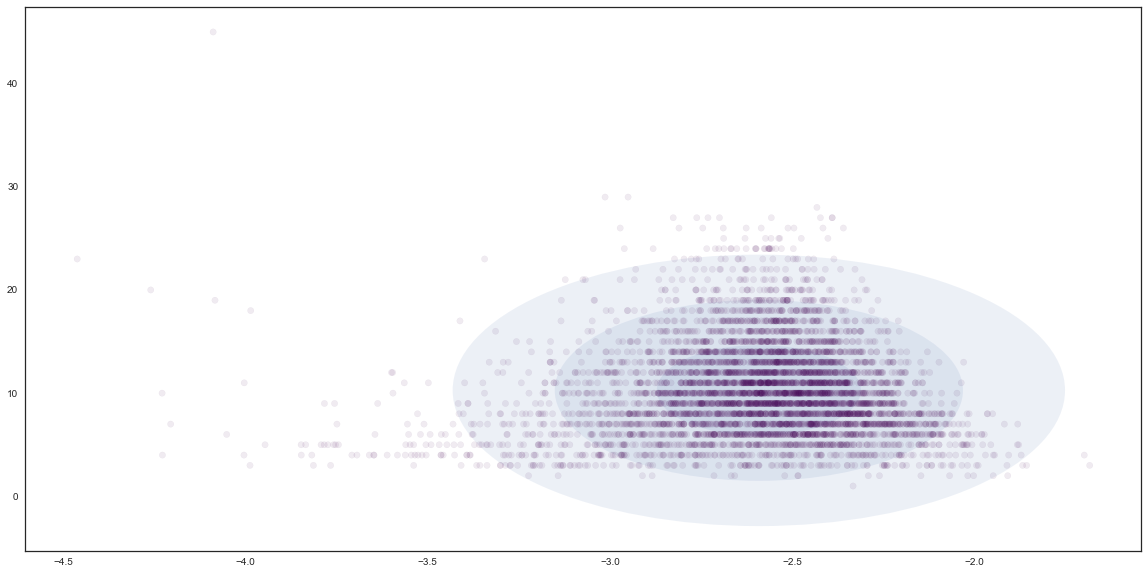

In [24]:
gmm = GMM(n_components=1, random_state=42)
plot_gmm(gmm, df_alexa1m[['LL','length']].as_matrix() )

Next, we'll plot the log liklihoods that each zeus and alexa1m domain belongs to our gaussian. 

/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


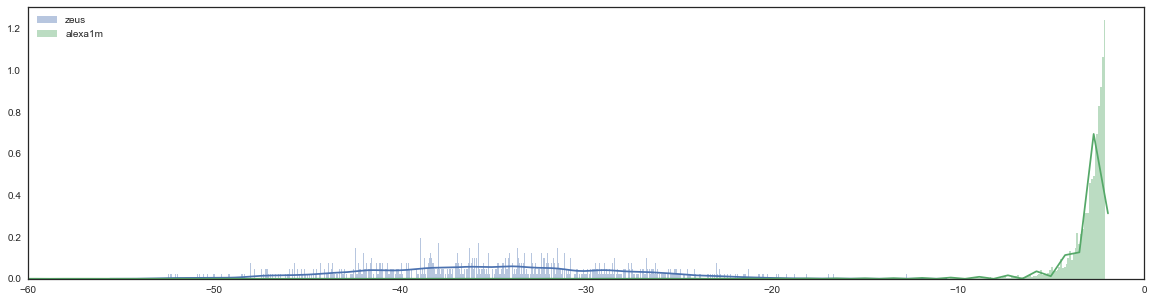

In [25]:
x1 = df_dgas[df_dgas.dga_family == 'zeus'][['LL','length']]
dga_scores = gmm.score( x1 )

x1 = df_alexa1m[['LL','length']]
alexa1m_scores = gmm.score( x1 )

plt.figure(figsize=(20,5))
sns.distplot(dga_scores,label='zeus',bins=1000)
sns.distplot(alexa1m_scores,label='alexa1m',bins=1000)
plt.xlim(-60,0)
plt.legend()
plt.show()

This is great, we see that zeus domains have MUCH lower log liklihoods. If we so wanted, we could use our KDE trick on the LL of our GMM. Let's try it.

In [26]:
kde = Kernel_Density_Estimate(bandwidth=.1)
kde.train( alexa1m_scores )
x = np.linspace(-60,0,1000)
pdf = kde.predict(x)

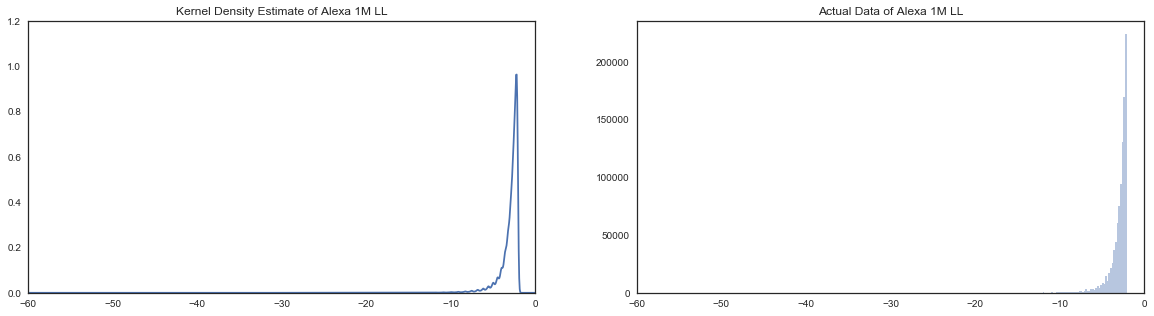

In [27]:
fig = plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(x,pdf)
plt.xlim(-60,0)
plt.ylim(0,1.20)
plt.title("Kernel Density Estimate of Alexa 1M LL")

plt.subplot(1, 2, 2)
sns.distplot(alexa1m_scores, kde=False, bins=500)
plt.xlim(-60,0)
plt.title("Actual Data of Alexa 1M LL")
plt.show()

In [28]:
cdf = 100.00 * pdf / pdf.sum()
cdf = cdf.cumsum()

lower_bound = x[ cdf[cdf <= .5].shape[0] ].round(2)
upper_bound = x[ cdf[cdf <= 99.5].shape[0] ].round(2)
print "99% Credible Interval for LL: {} : {}".format(lower_bound, upper_bound)

DGA_Anomalies = 0
for LL in dga_scores:
    if LL < lower_bound or LL > upper_bound:
        DGA_Anomalies += 1
        
Alexa_Anomalies = 0
for LL in alexa1m_scores:
    if LL < lower_bound or LL > upper_bound:
        Alexa_Anomalies += 1
        
dgas_caught = np.round(100.0 * DGA_Anomalies / dga_scores.shape[0],1)
alexa1m_caught = np.round(100.0 * Alexa_Anomalies / alexa1m_scores.shape[0],1)

print "Percent of Zeus Domains Caught: {}% \nPercent of Alexa 1M Domains Caught: {}%".format(dgas_caught,alexa1m_caught)

99% Credible Interval for LL: -11.41 : -1.92
Percent of Zeus Domains Caught: 100.0% 
Percent of Alexa 1M Domains Caught: 0.5%


Wow, now we've caught all of the zeus domains without increasing the number of alexa1m domains caught! 

However, let's consider our calculation from earlier. 

We'll use the same assumptions as before, but with the one tailed 99.5% credibility interval. 

$1.0 * 10,000 = 10,000$ <br>
$0.0 * 10,000 = 0$ <br>

We catch 9,990 DGAs and miss 10 at the 99% credible interval.

$.005 * 9,990,000 = 49,950$ <br>
$.995 * 9,990,000 = 9,940,050$ <br>

We still have about 8 / 10 domains sent to our human agents that will NOT be malicious! Let's try using a one tailed 99.9% credible interval and see what happens.

In [29]:
cdf = 100.00 * pdf / pdf.sum()
cdf = cdf.cumsum()

lower_bound = x[ cdf[cdf <= .1].shape[0] ].round(2)
print "99.9% Credible Interval for LL: <{}".format(lower_bound)

DGA_Anomalies = 0
for LL in dga_scores:
    if LL < lower_bound:
        DGA_Anomalies += 1
        
Alexa_Anomalies = 0
for LL in alexa1m_scores:
    if LL < lower_bound:
        Alexa_Anomalies += 1
        
dgas_caught = np.round(100.0 * DGA_Anomalies / dga_scores.shape[0],1)
alexa1m_caught = np.round(100.0 * Alexa_Anomalies / alexa1m_scores.shape[0],1)

print "Percent of Zeus Domains Caught: {}% \nPercent of Alexa 1M Domains Caught: {}%".format(dgas_caught,alexa1m_caught)

99.9% Credible Interval for LL: <-21.26
Percent of Zeus Domains Caught: 98.6% 
Percent of Alexa 1M Domains Caught: 0.1%


We'll use the same assumptions as before, but with the one tailed 99.5% credibility interval. 

$.987 * 10,000 = 9870$ <br>
$.015 * 10,000 = 130$ <br>

We catch 9,990 DGAs and miss 10 at the 99% credible interval.

$.001 * 9,990,000 = 9,990$ <br>
$.999 * 9,990,000 = 9,980,010$ <br>

Now only about 5 / 10 domains sent to our human agents that will NOT be malicious! Pretty neat right? We're catching about the same volume of DGAs, but we're using our human agents much more efficiently. It should be noted that you can tune discriminators in a very similar way as we've tuned the output of our generative model, but I won't cover that here.

Just for fun let's try using more than one Gaussian component. I won't get into how I arrived at 2 components (honestly, there are many evaluation metrics you can use like AIC, BIC, discriminator attributes, etc.). I leave it to the reader to delve into the wacky world of mixed models and their components.

/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Us

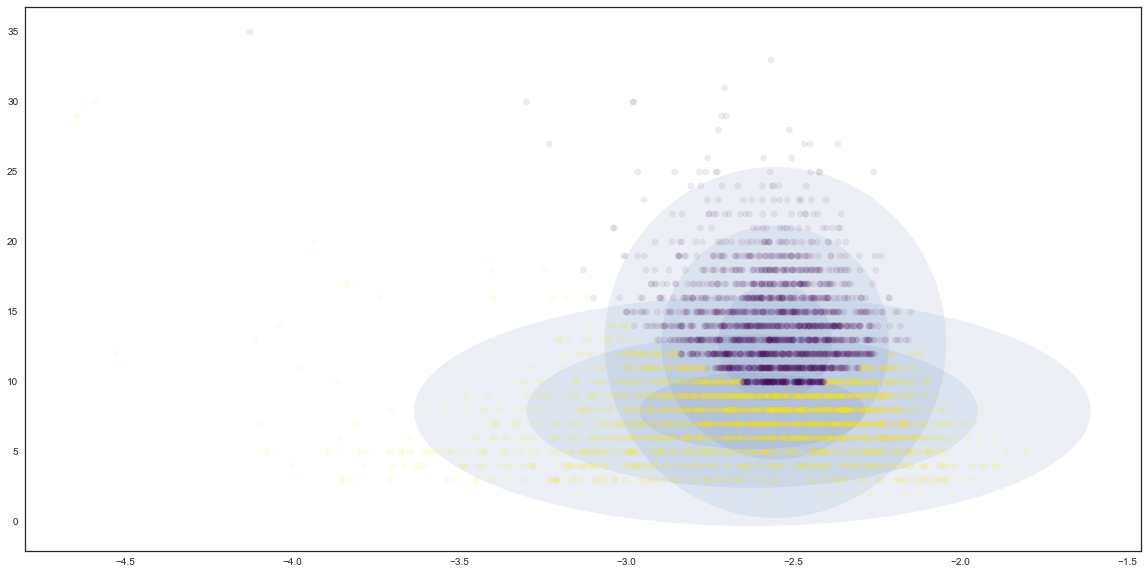

In [30]:
gmm = GMM(n_components=2, random_state=42)
plot_gmm(gmm, df_alexa1m[['LL','length']].as_matrix() )

/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


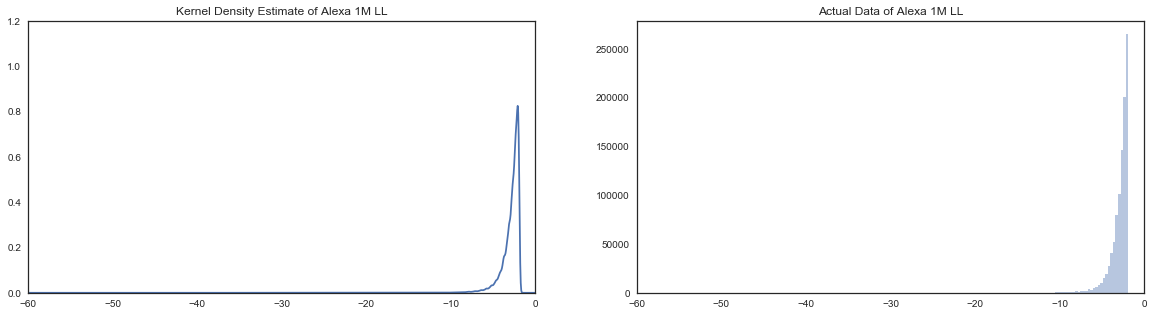

In [31]:
x1 = df_dgas[df_dgas.dga_family == 'zeus'][['LL','length']]
dga_scores = gmm.score( x1 )

x1 = df_alexa1m[['LL','length']]
alexa1m_scores = gmm.score( x1 )

kde = Kernel_Density_Estimate(bandwidth=.1)
kde.train( alexa1m_scores )
x = np.linspace(-60,0,1000)
pdf = kde.predict(x)

fig = plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(x,pdf)
plt.xlim(-60,0)
plt.ylim(0,1.20)
plt.title("Kernel Density Estimate of Alexa 1M LL")

plt.subplot(1, 2, 2)
sns.distplot(alexa1m_scores, kde=False, bins=500)
plt.xlim(-60,0)
plt.title("Actual Data of Alexa 1M LL")
plt.show()

In [32]:
cdf = 100.00 * pdf / pdf.sum()
cdf = cdf.cumsum()

lower_bound = x[ cdf[cdf <= .1].shape[0] ].round(2)
print "99.9% Credible Interval for LL: <{}".format(lower_bound)

DGA_Anomalies = 0
for LL in dga_scores:
    if LL < lower_bound:
        DGA_Anomalies += 1
        
Alexa_Anomalies = 0
for LL in alexa1m_scores:
    if LL < lower_bound:
        Alexa_Anomalies += 1
        
dgas_caught = np.round(100.0 * DGA_Anomalies / dga_scores.shape[0],1)
alexa1m_caught = np.round(100.0 * Alexa_Anomalies / alexa1m_scores.shape[0],1)

print "Percent of Zeus Domains Caught: {}% \nPercent of Alexa 1M Domains Caught: {}%".format(dgas_caught,alexa1m_caught)

99.9% Credible Interval for LL: <-20.54
Percent of Zeus Domains Caught: 100.0% 
Percent of Alexa 1M Domains Caught: 0.1%


Well slap my knee and call me Greg, those are some great results! Now I will note that I chose the zeus DGA family because they are actually very easy to identify using either a generator or discriminator. I leave it to the reader to see how the generator works on the other families of DGAs in our dataset.

One last note, based on the math from before 50% of the anomalies our model detects will be actual malicious DGAs. However, we are detecting ~20,000 anomalies a day! Let's say we have 100 human agents that can each go through 60 DGAs in a full work day. We're only vetting 6000 anomalies a day (and that's assuming that it's a good day for the human agents and that no one is sick or tired or just having an off day). 

Naively we might assume that 50% of the 6000 vetted are DGAs and so we only actually catch about 30% of the zeus DGAs in our proxy logs due to the bandwidth limitations of our agents. The real picture is a little more rosy. It turns out that we could rank order which anomalies our agents look at first by their log likelihood scores. Less likely domains go to the top of the agent's queue. For the zeus case we would then detect 6000 DGAs a day (I leave it to the reader to confirm this if they don't trust me)...but 6000 is still only 60% of the zeus DGAs in our proxy logs!

Yep, cyber security sucks, but we've been able to make it suck a lot less by intelligently using our generative model to make the most efficient use of our human agents. Discriminators are much better at identifying different classes, but are terrible at making predictions outside of their training sets. I often try to (although I have not seen this in production elsewhere) create a generator to determine the probability that a new test sample was generated from the same process as my training data. If I get a decent likelihood score, I then run the sample through a discriminator. I then get the benefits of the discriminator but have an early warning system in case I suddenly start seeing domains that are unlike any domains (malignant or benign) that I have ever seen before (which may be a sign that there is a new DGA in the wild unlike any of the old ones). 

I have very strong opinions about how uncertainties in modeling could be improved using statistics, but too often in practice data scientists rush to production and don't have time to create robust models that really take into account likelihood uncertainty, model uncertainty, and out-of-sample uncertainty. I'd like to one day post a small tutorial on fully accounting for uncertainty in a model.

### Let's create our own DGA!

Before we close out this fun adventure with generative models, let's look at one more cool feature of them. Since our model is generative in nature, we can actually generate fake examples of alexa1m domains. Since these are fake domains, we could actually use them as a DGA to fool DGA detectors into thinking they are Alexa1M domains!

**Don't try using this DGA in a real attack!** Firstly, there is more to creating malware than creating a decent DGA. Secondly, you will get caught and the repercussions can be HUGE. Lastly, malicious hacking is immoral, get a real job. While I love thinking about how to break through various cyber security defenses, I would never put on a black hat. 

So if we aren't going to use this DGA in a cyber security attack, how might we use it? Well, we could use it in adversarial training to build a discriminator that can tell real alexa1m domains from fake alexa1m domains created using markov chains. We would need to be careful, however, because using a generator in this way can introduce major bias into this model. 

Anyhoo, let's look at our sample domains...

In [33]:
def markov_dga_generator():
    domain = [38]
    while domain[-1] <> 39 and len(domain) <= 12:
        a = domain[-1]
        d = np.random.choice( [i for i in range(transition_matrix.shape[0])] , 1, p=transition_matrix[a,:] )
        domain.append(d[0])
    domain = ''.join( [character_lookup_dict[char] for char in domain if char not in [38,39]] )
    return domain
    
markov_dgas = [markov_dga_generator() for i in range(20)]
markov_dgas

['pergyp',
 'watronav',
 'bp',
 '2umanckaceck',
 'onfretet-cho',
 'lels',
 'maao-sprin',
 'babmeayphopa',
 'texptue0',
 'ontare',
 'puagrvz',
 'ortevtlneden',
 'vuloontivede',
 'bo',
 'awcn-steryjc',
 'kyvecu',
 'tones',
 'h',
 'nery',
 'cinnkal']

### Final Words

There's a lot more I could say about generative models, but I'll contain myself. The key to a good generative model is to describe the data as best you can, but in trying to do so you will run into all of the same problems you would with classic inference problems. Therefore, I recommend taking a decent Bayesian statistics course where you can gain familiarity with the proper way to solve these kinds of problems estimating probability distributions.  

If you are looking to get some practice in with generative models, try building a generative model of alexa one million that can identify matsnu (a famous dictionary dga included in our dataset) domains as anomalies. If you want an extra hard challenge, try detecting pushdo domains as anomalies!

If you want to move past markov models as generators. I recommend looking at building mixture models or embeddings. However, Markov models are pretty great and I'll have future posts on Markov Decision Processes and Hidden markov Models (I also cover Markov switching models in my time series course).

For example, try build a domain2vec model to identify important latent variables describing a domain and then model clusters within that embedding space with a Gaussian mixture model. Alternatively, you could create an auto-encoder trained on the alexa one million data and use the reconstruction errors to identify domains that are dissimilar to alexa one million. I won't go into detail on how to implement these ideas (at least not in this blog post).

Finally, try thinking about how you would use discriminators and generators together in a practical setting. Would it be wise to feed the output of the generator into the discriminator? (Think about the case where the generator is an auto-encoder and the discriminator is a simple neural net/multi layer perceptron)

Thanks for reading; I hope you found this post interesting and helpful!

### Post Scriptum (P.S.)

So after writing this tutorial I decided to go back and play with a GMM model that was 'trained' using full bayesian inference. I won't go into detail about that this means (feel free to read my tutorial on bayesian statistics if you are curious), but I do want to show my results. The advantage of this approach (although I don't explore it here) is that we can pull model uncertainty estimates. Anyway, I base my example off of this [edward code](http://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/unsupervised.ipynb) for simplicity. Feel free to read through that notebook to build intuition around what I am doing. 

One neat benefit of the approach below is that I won't have to bother with kde at all and can jsut use actual probabilities from my gaussian componenents. 

Also note that edward is almsot fully integrated into tensorflow contrib, so you can just rebuild this work in tf if you so choose. 

Warning! Because the GMM below is 'trained' using full bayesian inference and I make predictions using very small samples approximating the posterior, the code below yields variable results and the numbers don't always line up with my comments. If you have the time and want more reliability from the model, increase the epochs during the inference step and take more samples of the posterior when making predictions. 

In [34]:
from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture)
import tensorflow as tf
import edward as ed

x_train = df_alexa1m[['LL','length']]
x_train = np.asmatrix(x_train)

N, D = x_train.shape  # number of data points, dimensionality of data

K = 2  # number of components

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

T = 500  # number of MCMC samples
qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


  5/500 [  1%]                                ETA: 1661s | Acceptance Rate: 1.000
Inferred cluster means:
[[-2.5934129  10.237402  ]
 [ 0.25191498  1.1022897 ]]
 10/500 [  2%]                                ETA: 1410s | Acceptance Rate: 1.000
Inferred cluster means:
[[-2.5978966 10.232743 ]
 [-1.5547541  2.3266444]]
 15/500 [  3%]                                ETA: 1317s | Acceptance Rate: 1.000
Inferred cluster means:
[[-2.5884895 10.311139 ]
 [-2.1429956  3.1827257]]
 20/500 [  4%] █                              ETA: 1266s | Acceptance Rate: 1.000
Inferred cluster means:
[[-2.5821855 10.404123 ]
 [-2.3574507  3.638885 ]]
 25/500 [  5%] █                              ETA: 1229s | Acceptance Rate: 1.000
Inferred cluster means:
[[-2.5846856 10.449849 ]
 [-2.4612756  3.940523 ]]
 30/500 [  6%] █                              ETA: 1200s | Acceptance Rate: 1.000
Inferred cluster means:
[[-2.5843825 10.484438 ]
 [-2.5249696  4.1604457]]
 35/500 [  7%] ██                             ETA: 117

In [35]:
# Make predictions for alexa domains
x_train = df_alexa1m[['LL','length']]
x_train = np.asmatrix(x_train)
N, D = x_train.shape

mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))

x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])
x_broadcasted = tf.to_float(x_broadcasted)

d = x_post.prob(x_broadcasted).eval()
# multiply out over latent variables
d = d.prod(axis=3)
# take the expectation across samples
e = d.mean(axis=1)

In [36]:
# Make predictions for zeus domains
x = df_dgas[df_dgas.dga_family == 'zeus'][['LL','length']]
x = np.asmatrix(x)
N, D = x.shape  

x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))

x_broadcasted = tf.tile(tf.reshape(x, [N, 1, 1, D]), [1, 100, K, 1])
x_broadcasted = tf.to_float(x_broadcasted)

d = x_post.prob(x_broadcasted).eval()
# multiply out over latent variables
d = d.prod(axis=3)
# take the expectation across samples
f = d.mean(axis=1)

In [37]:
# take the mean probability across mixture components
e = e.mean(axis=1)
f = f.mean(axis=1)

In [38]:
alexa1m_caught = 100.0 * e[e < .001].shape[0] / e.shape[0]
dgas_caught = 100.0 * f[f < .001].shape[0] / f.shape[0]
print "Percent of Zeus Domains Caught: {}% \nPercent of Alexa 1M Domains Caught: {}%".format(dgas_caught,alexa1m_caught)

Percent of Zeus Domains Caught: 100.0% 
Percent of Alexa 1M Domains Caught: 1.0901%


We'll use the same assumptions as in the original post to assess efficacy.

$.999 * 10,000 = 9990$ <br>
$.001 * 10,000 = 10$ <br>

We catch 9,990 DGAs and miss 10 at the 99% credible interval.

$.003 * 9,990,000 = 29,970$ <br>
$.997 * 9,990,000 = 9,960,030$ <br>

These results are pretty neat. We basicaly get similar resutls as before (3/10 anaomalies are DGAs). Let's just try this with a different probability threshold.

In [39]:
alexa1m_caught = 100.0 * e[e < .0001].shape[0] / e.shape[0]
dgas_caught = 100.0 * f[f < .0001].shape[0] / f.shape[0]
print "Percent of Zeus Domains Caught: {}% \nPercent of Alexa 1M Domains Caught: {}%".format(dgas_caught,alexa1m_caught)

Percent of Zeus Domains Caught: 100.0% 
Percent of Alexa 1M Domains Caught: 0.4215%


$.73 * 10,000 = 7,300$ <br>
$.27 * 10,000 = 2,700$ <br>

We catch 9,990 DGAs and miss 10 at the 99% credible interval.

$.00654 * 9,990,000 = 6,533$ <br>
$.99999346 * 9,990,000 = 9,983,467$ <br>

We're now getting a ratio of about 1:1 in our detected anomalies of DGAs vs Benign Domains! We're also doing this in a much simpler way than before (no need for kde). While we're not catching 100% of the zeus domains in our model, this is a much more practical framework if we are to utilize human agents to comb through our anomalies.